# setup

In [1]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/new/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xcg_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-yjkql0lh
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-yjkql0lh
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=785bcde95b6a2bb8cbe5bdeb612df80500e8fe7a211ea0bdbb34a63a08ba250f
  Stored in directory: /tmp/pip-ephem-wheel-cache-474h6205/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl
GPU mem:16G, batch_size:256


In [ ]:
int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16

256

# model

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state


In [ ]:
import gc

my_model.cpu()
del my_model
gc.collect()
torch.cuda.empty_cache()

# Training

(247117, 156) (247117, 134) 19
0.050000   -0.706030
0.087593   -0.502089
0.125185   -0.384047
0.162778   -0.297070
0.200370   -0.236943
0.237963   -0.187761
0.275556   -0.145808
0.313148   -0.109070
0.350741   -0.077414
0.388333   -0.046000
0.487504    0.015920
0.538254    0.052490
0.589004    0.093600
0.639753    0.136890
0.690503    0.184898
0.741252    0.237020
0.792002    0.294390
0.842751    0.369647
0.893501    0.483800
0.944250    0.669730
0.995000    1.452164
Name: close, dtype: float64


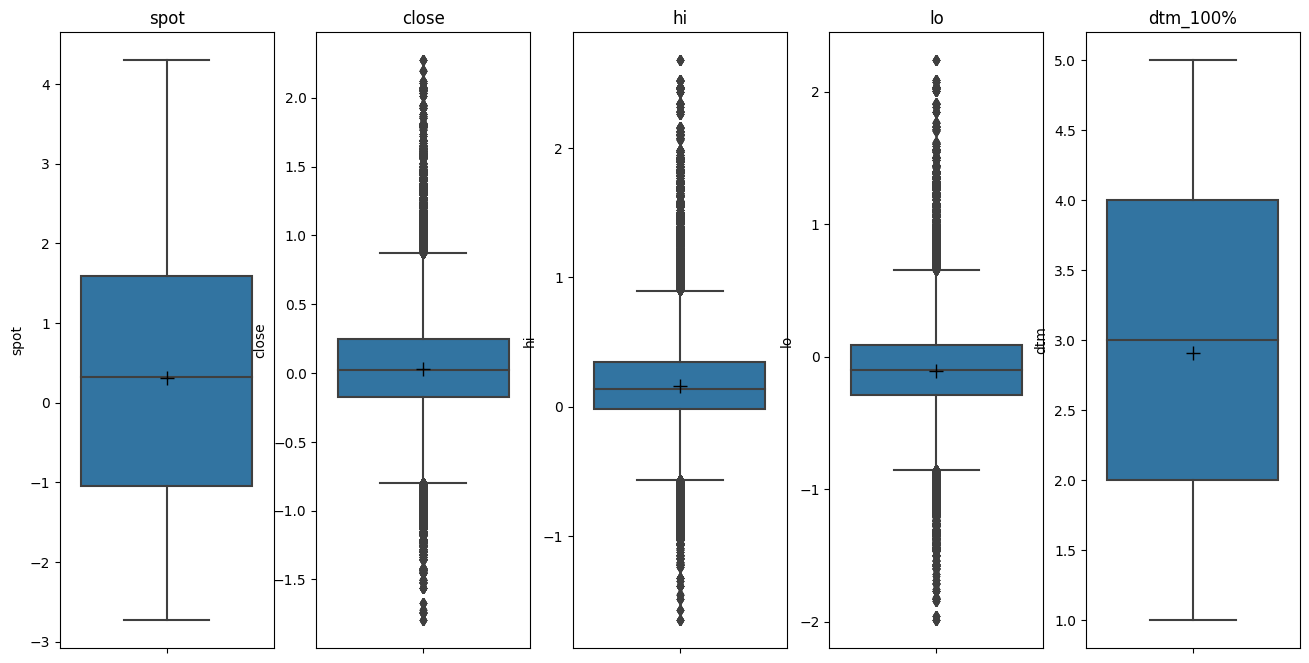

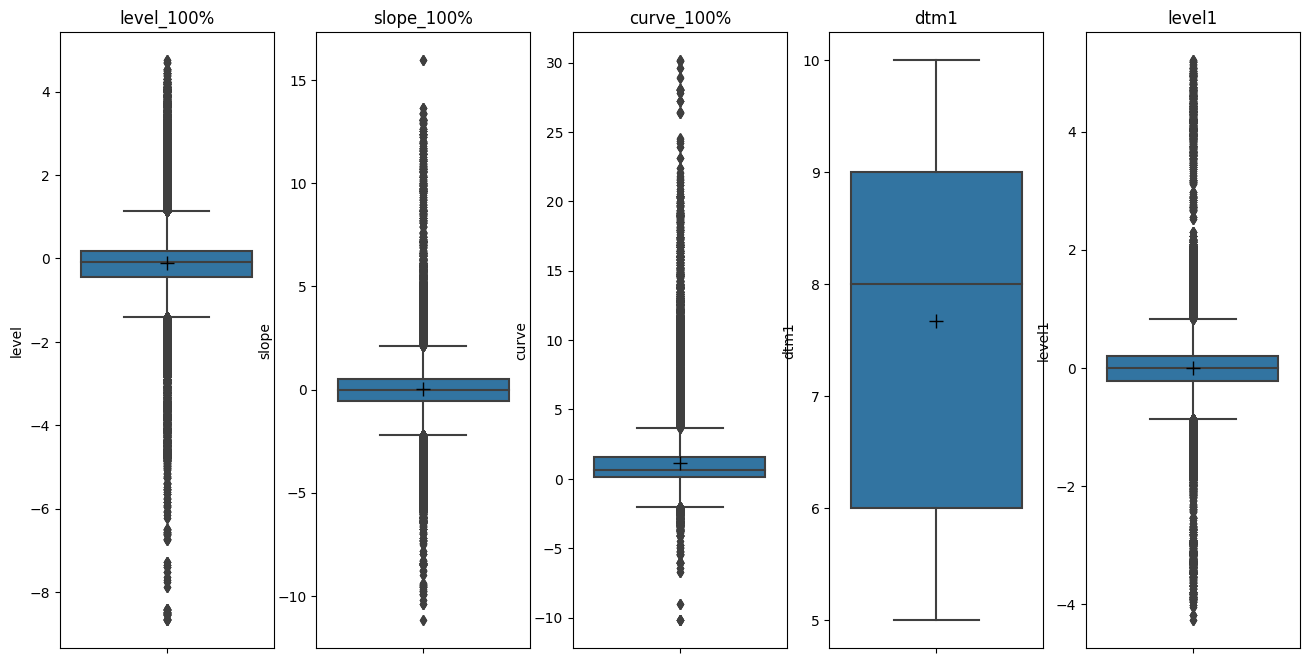

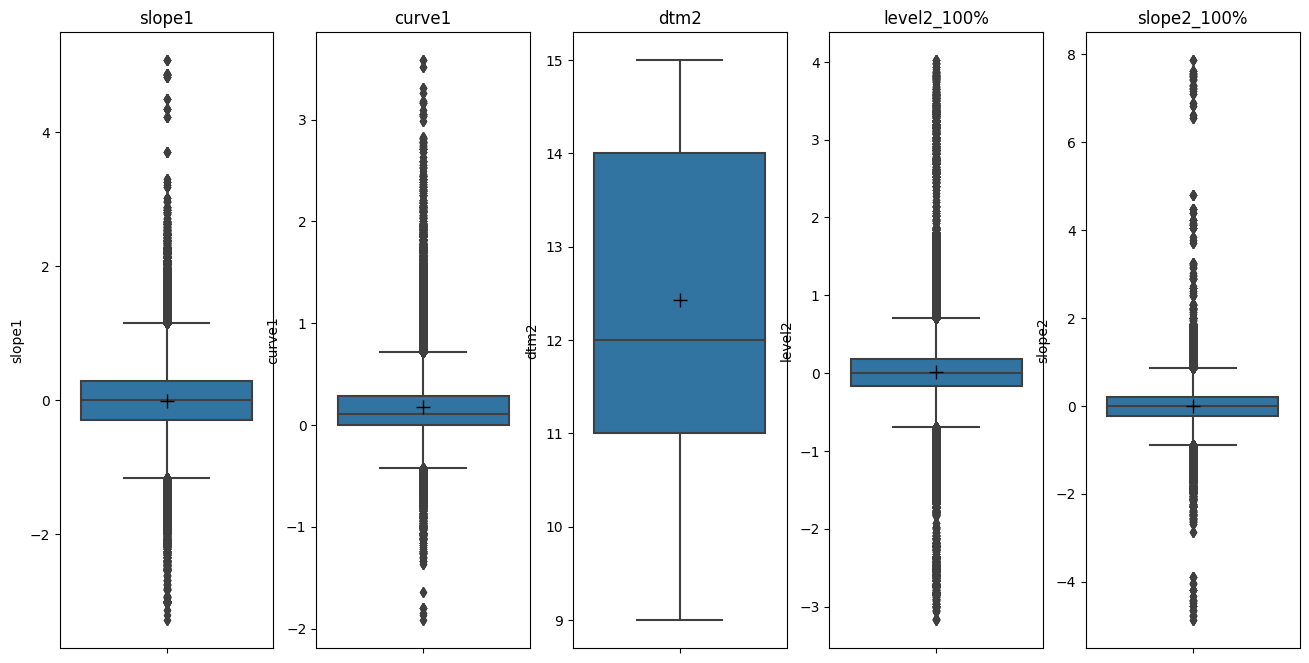

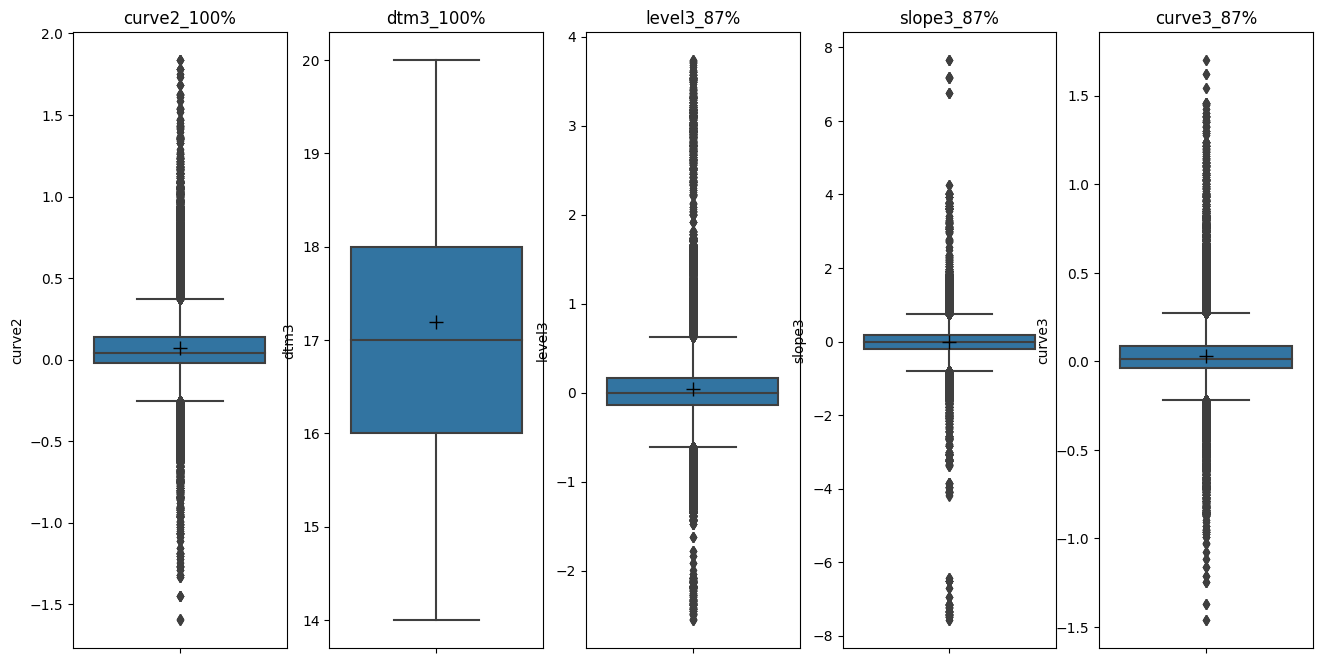

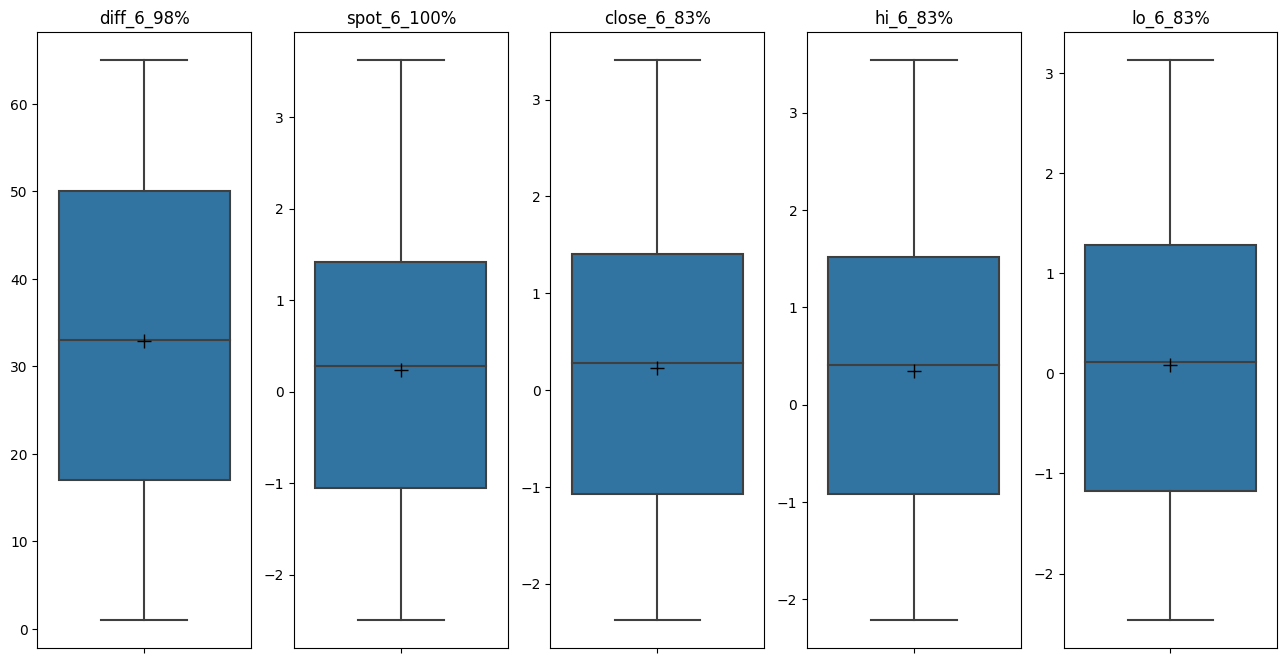

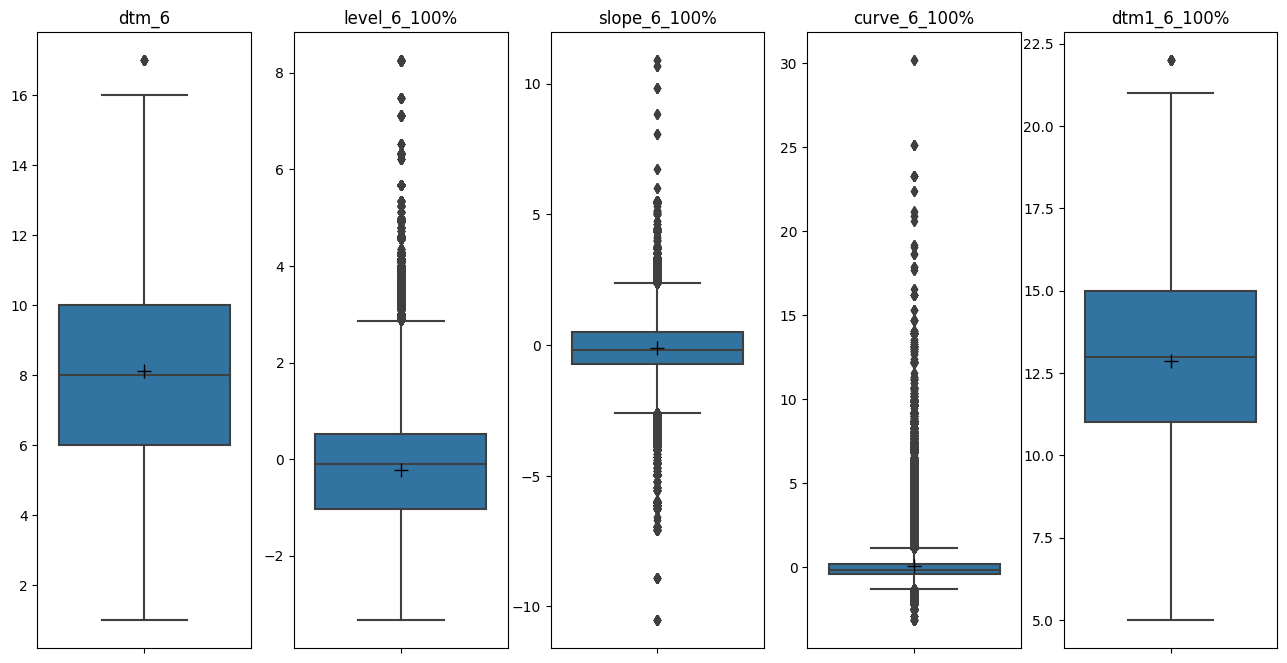

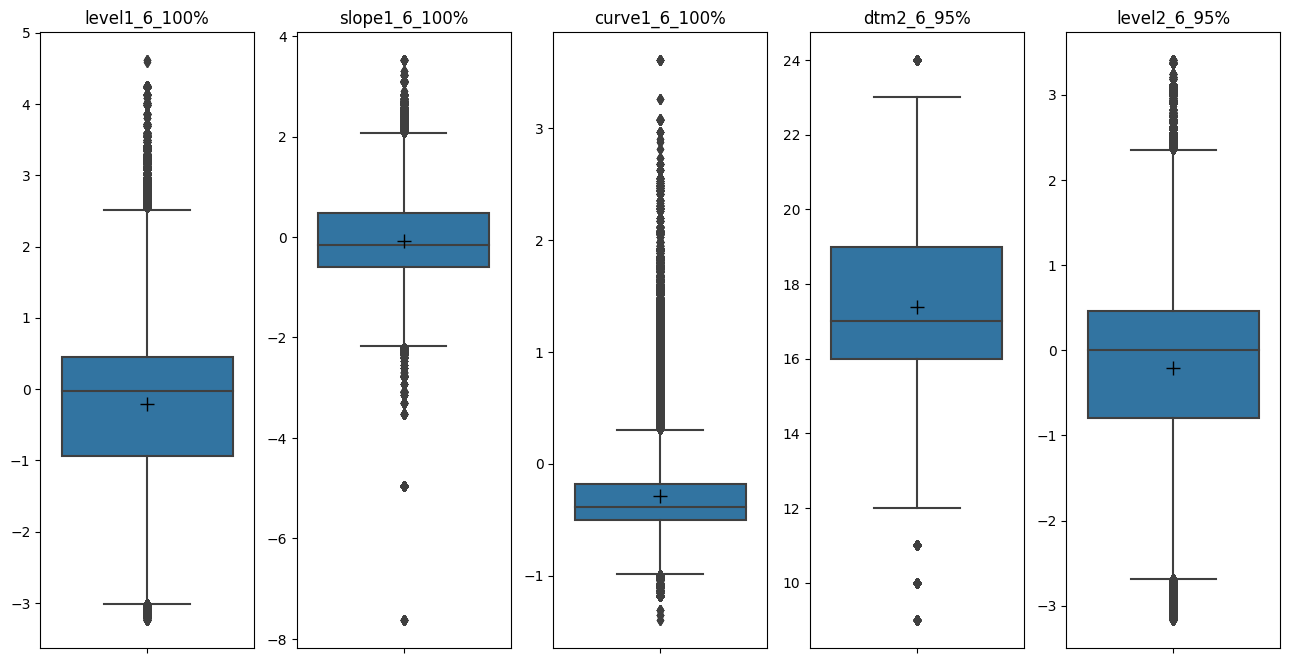

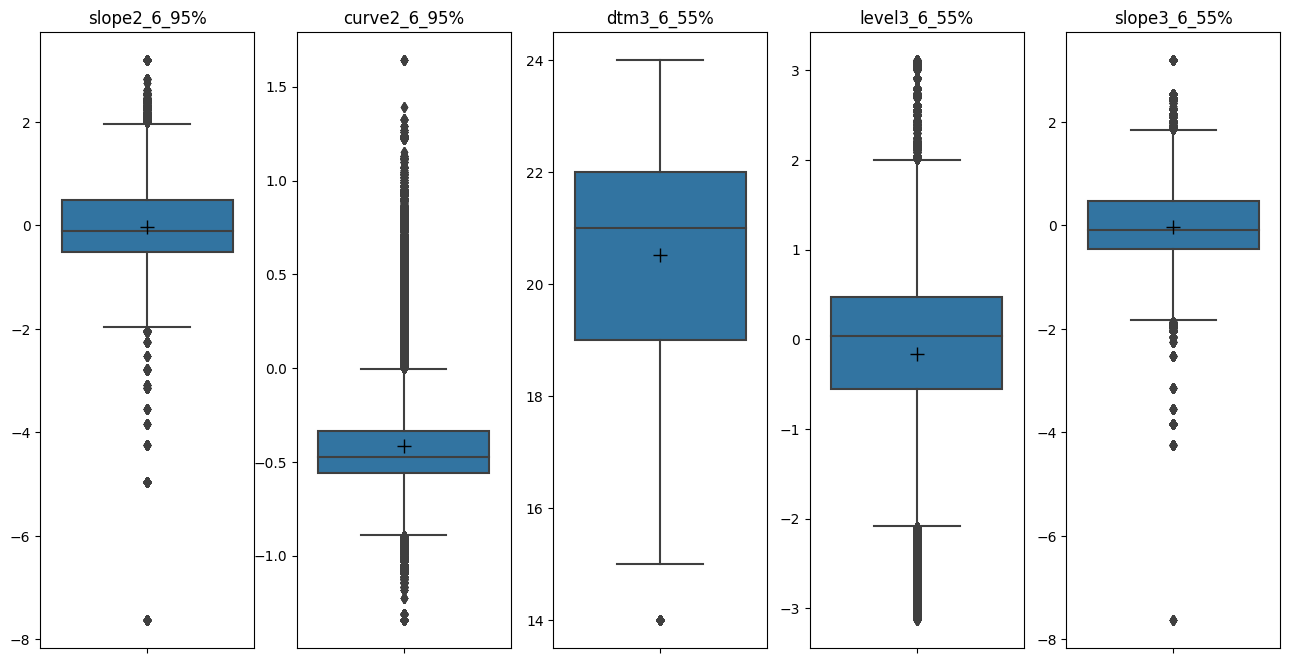

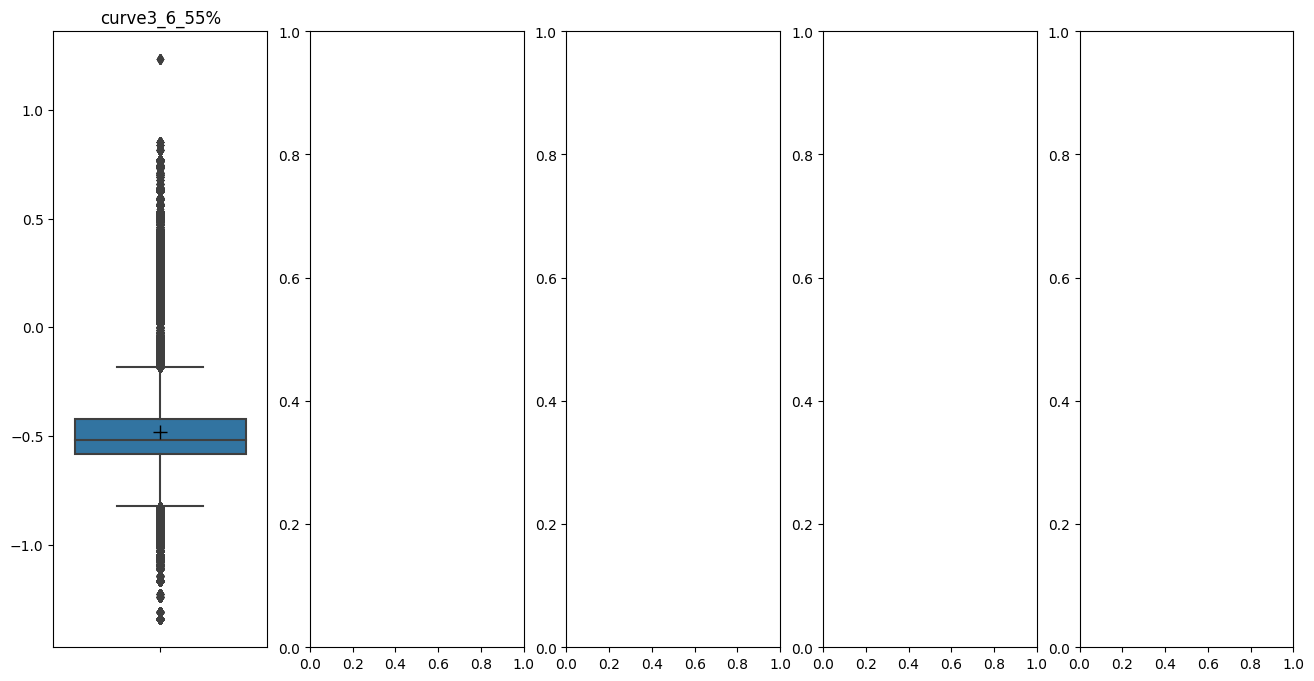

In [3]:
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[dfo['dtm_1']>15].iloc[0])

date            #2022-06-24 16:00:07#
Horizon                           5.0
dtm                                 5
spot                         -1.35736
level                        -1.26966
slope                        -0.20132
curve                         0.58794
dtm1                                9
level1                       -1.12212
slope1                       -0.03886
curve1                        0.32424
dtm2                               14
level2                       -1.02512
slope2                        0.30494
curve2                       -0.01554
dtm3                               19
level3                       -99999.0
slope3                       -99999.0
curve3                       -99999.0
date_1                    44720.41595
date_2                    44721.66555
date_3                    44722.66425
date_4                     44725.6638
date_5                    44727.58959
date_6                     44728.5474
diff_1                             54
diff_2      

# run


Xcg_close,hi torch.Size([247117, 20])
PETrans 6 16 132 [] 40 2
loaded Xcg_close,hi epoch 82
offset  -68228
torch.Size([201400, 0]) torch.Size([201400, 22, 6]) torch.Size([201400, 20])
Xcg_close,hi 1.6231


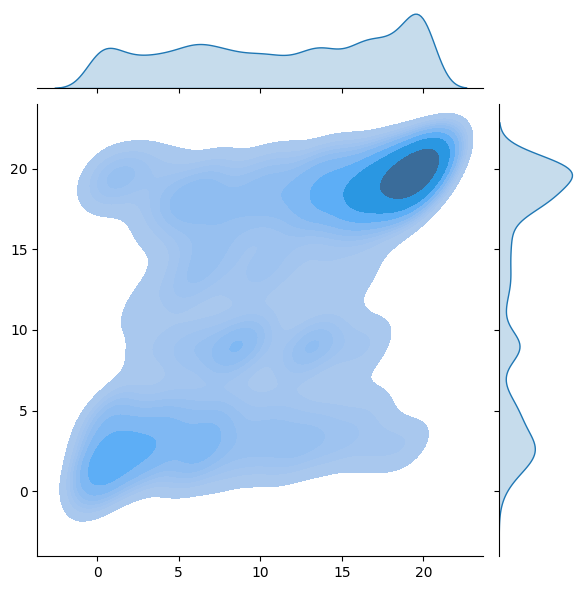

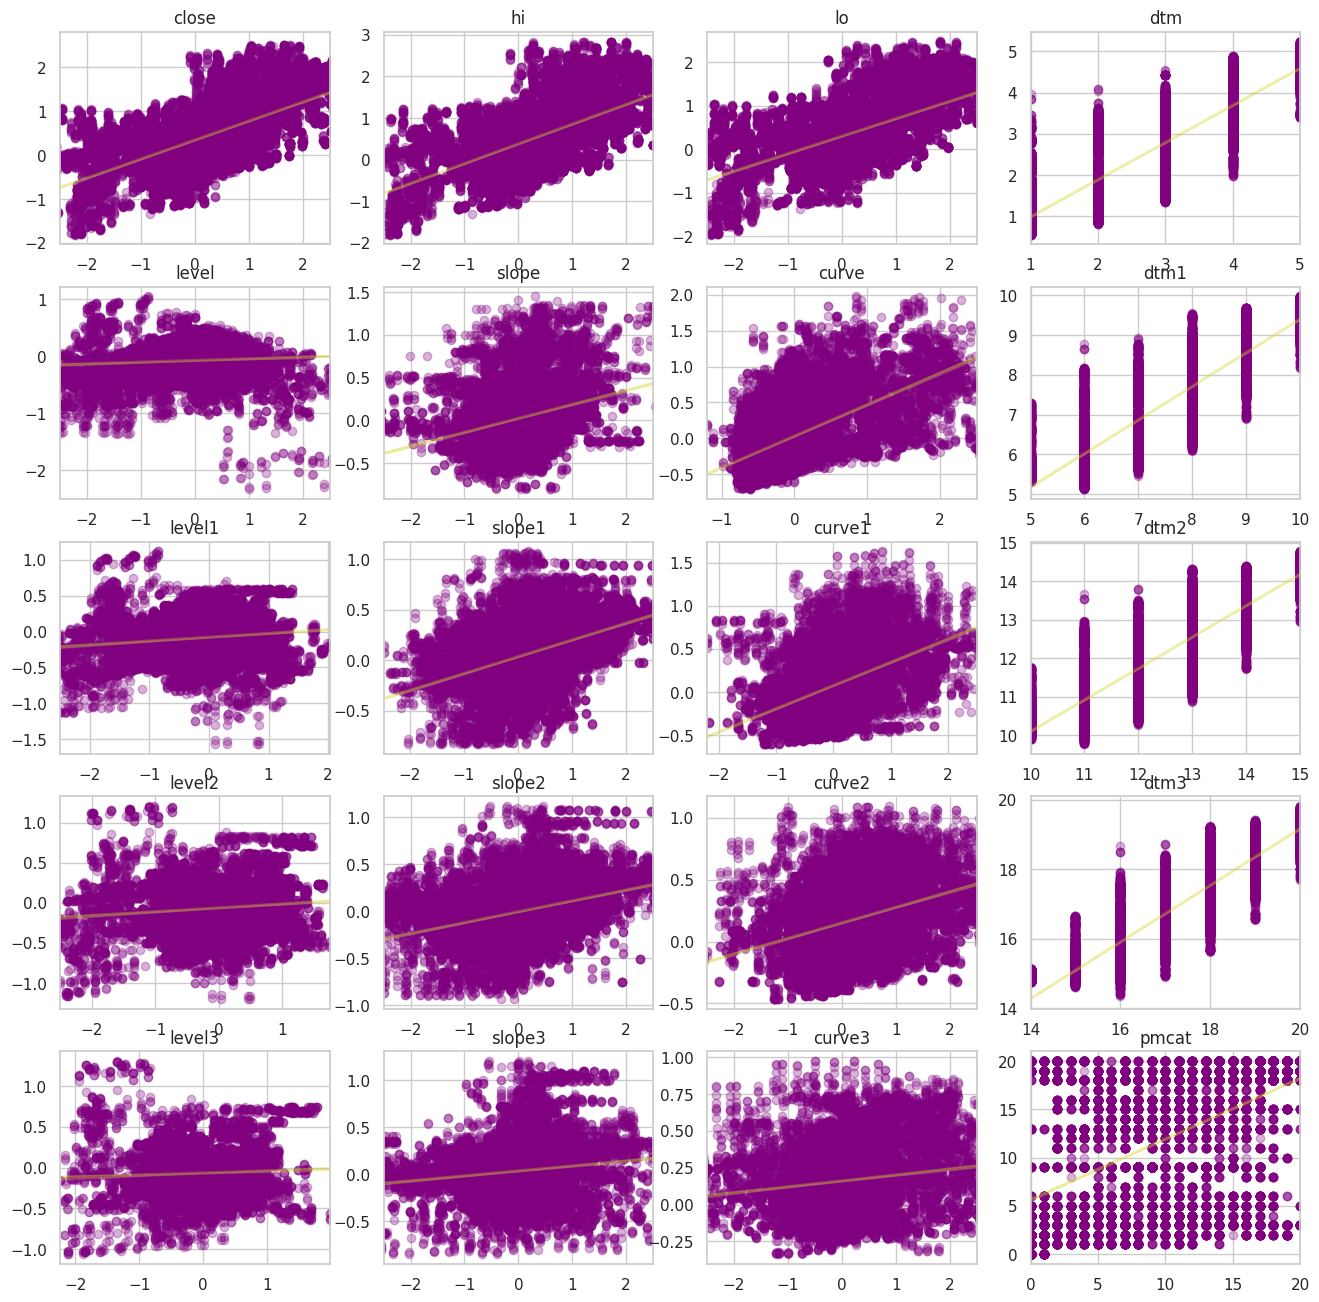

Epoch 082 | Validation score: 1.5635  <<< BEST VALIDATION EPOCH
Epoch 083 | Validation score: 1.5858  no improve 1
Epoch 084 | Validation score: 1.5903  no improve 2
Epoch 085 | Validation score: 1.5864  no improve 3
Epoch 086 | Validation score: 1.5664  no improve 4
Epoch 087 | Validation score: 1.5795  no improve 5
Epoch 088 | Validation score: 1.5757  no improve 6
Epoch 089 | Validation score: 1.5791  no improve 7
Epoch 090 | Validation score: 1.5603  <<< BEST VALIDATION EPOCH
Epoch 091 | Validation score: 1.5704  no improve 1
loaded Xcg_close,hi epoch 92
Epoch 092 | Validation score: 1.5781  no improve 2
Epoch 093 | Validation score: 1.5776  no improve 3
Epoch 094 | Validation score: 1.5900  no improve 4
Epoch 095 | Validation score: 1.5636  no improve 5
Epoch 096 | Validation score: 1.5558  <<< BEST VALIDATION EPOCH
Epoch 097 | Validation score: 1.5817  no improve 1
Epoch 098 | Validation score: 1.5583  no improve 2
Epoch 099 | Validation score: 1.5337  <<< BEST VALIDATION EPOCH
E

In [ ]:
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

## manual

In [ ]:

    # setup_data(0)
    prediction = []
    i=0
    with torch.no_grad():
      my_model.eval()
      for batch in zero.iter_batches(X['test'], batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
        prediction.append(apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y['test']#[i:i+batch_size]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    score,target, prediction


Xcf_dtm, lev torch.Size([231363, 16])
PETrans 6 16 132 [] 16 2
loaded Xcf_dtm, lev epoch 74
offset  -64321


(tensor(0.7848, device='cuda:0'),
 tensor([[ 4.0000e+00, -1.3228e-02, -1.0274e-01,  ...,  1.0533e-01,
           9.5372e-01,  2.4700e-01],
         [ 2.0000e+00,  1.2167e-01, -1.5562e-02,  ..., -7.9616e-02,
           9.9181e-03, -1.7748e-01],
         [ 1.0000e+00, -8.4570e-01,  3.6727e-01,  ..., -1.1988e-01,
          -1.0307e+00,  1.2879e+00],
         ...,
         [ 2.0000e+00, -2.0026e+00,  1.0725e+00,  ..., -6.1677e-01,
           2.8542e-03,  3.8150e-02],
         [ 4.0000e+00, -1.3515e-01, -4.9724e-01,  ..., -3.6680e-02,
          -2.7041e-01, -4.6244e-01],
         [ 4.0000e+00, -1.9064e+00,  1.9062e-02,  ..., -1.5916e+00,
          -8.3080e-01,  6.4188e-01]], device='cuda:0'),
 tensor([[ 3.6312,  0.2111, -0.2651,  ...,  0.0109,  0.1032,  0.4787],
         [ 1.0670,  0.5796, -0.1153,  ...,  0.1862, -0.2249, -0.0291],
         [ 0.9954, -0.9162, -0.0798,  ..., -0.5044, -0.1970,  0.4467],
         ...,
         [ 1.7209,  0.0851,  0.0357,  ...,  0.0411,  0.1121,  0.0917],
     

In [ ]:
for i in range(len(target)):
  if target[i][0]==1 and prediction[i][0]>2:
    print(i,target[i],prediction[i])

15382 tensor([ 1.0000e+00,  6.0205e-01, -4.2817e-01,  1.0109e+00,  5.0000e+00,
         4.9149e-01, -2.0451e-01, -4.4114e-01,  1.0000e+01,  1.5667e-01,
         2.5629e-01, -7.5276e-01,  1.5000e+01,  1.1539e-01, -9.2124e-01,
        -6.9835e-03], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2171,  0.0882,  0.0640, -0.2971, 16.9601,  0.0372,  0.1261, -0.1165],
       device='cuda:0')
18262 tensor([ 1.0000e+00,  3.3884e-02,  2.2153e-03, -5.6351e-01,  5.0000e+00,
         2.6321e-02, -6.4948e-01, -7.7102e-02,  1.0000e+01, -5.2886e-02,
        -4.5381e-01, -2.7395e-01,  1.5000e+01, -7.9756e-02, -5.3078e-01,
        -5.1002e-02], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2170,  0.0882,  0.0641, -0.2971, 16.9601,  0.0371,  0.1262, -0.1164],
       device='cuda:0')


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)&(dfo['Horizon']<4)].iloc[10])

date            #2022-10-06 10:29:58#
Horizon                             2
spot                         -0.94172
dtm                                 1
level                        -0.13269
slope                         1.34783
curve                         0.38551
dtm1                                6
level1                        0.06577
slope1                        0.27589
curve1                        0.10309
dtm2                               11
level2                        0.10553
slope2                         0.2063
curve2                        0.06762
dtm3                               16
level3                        0.09173
slope3                        0.19436
curve3                       -0.00611
date_1                    44827.66397
date_2                    44830.66464
date_3                    44833.57739
date_4                    44834.44378
date_5                     44837.3959
date_6                    44838.55333
diff_1                             19
diff_2      

Xcg_close,hi 28216.7461


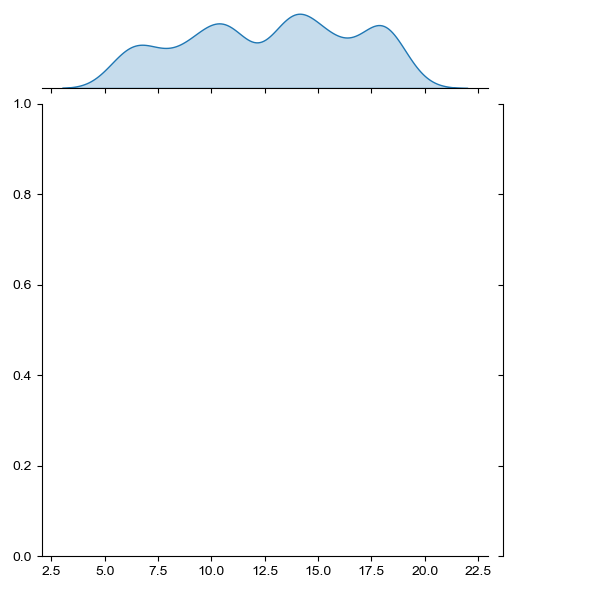

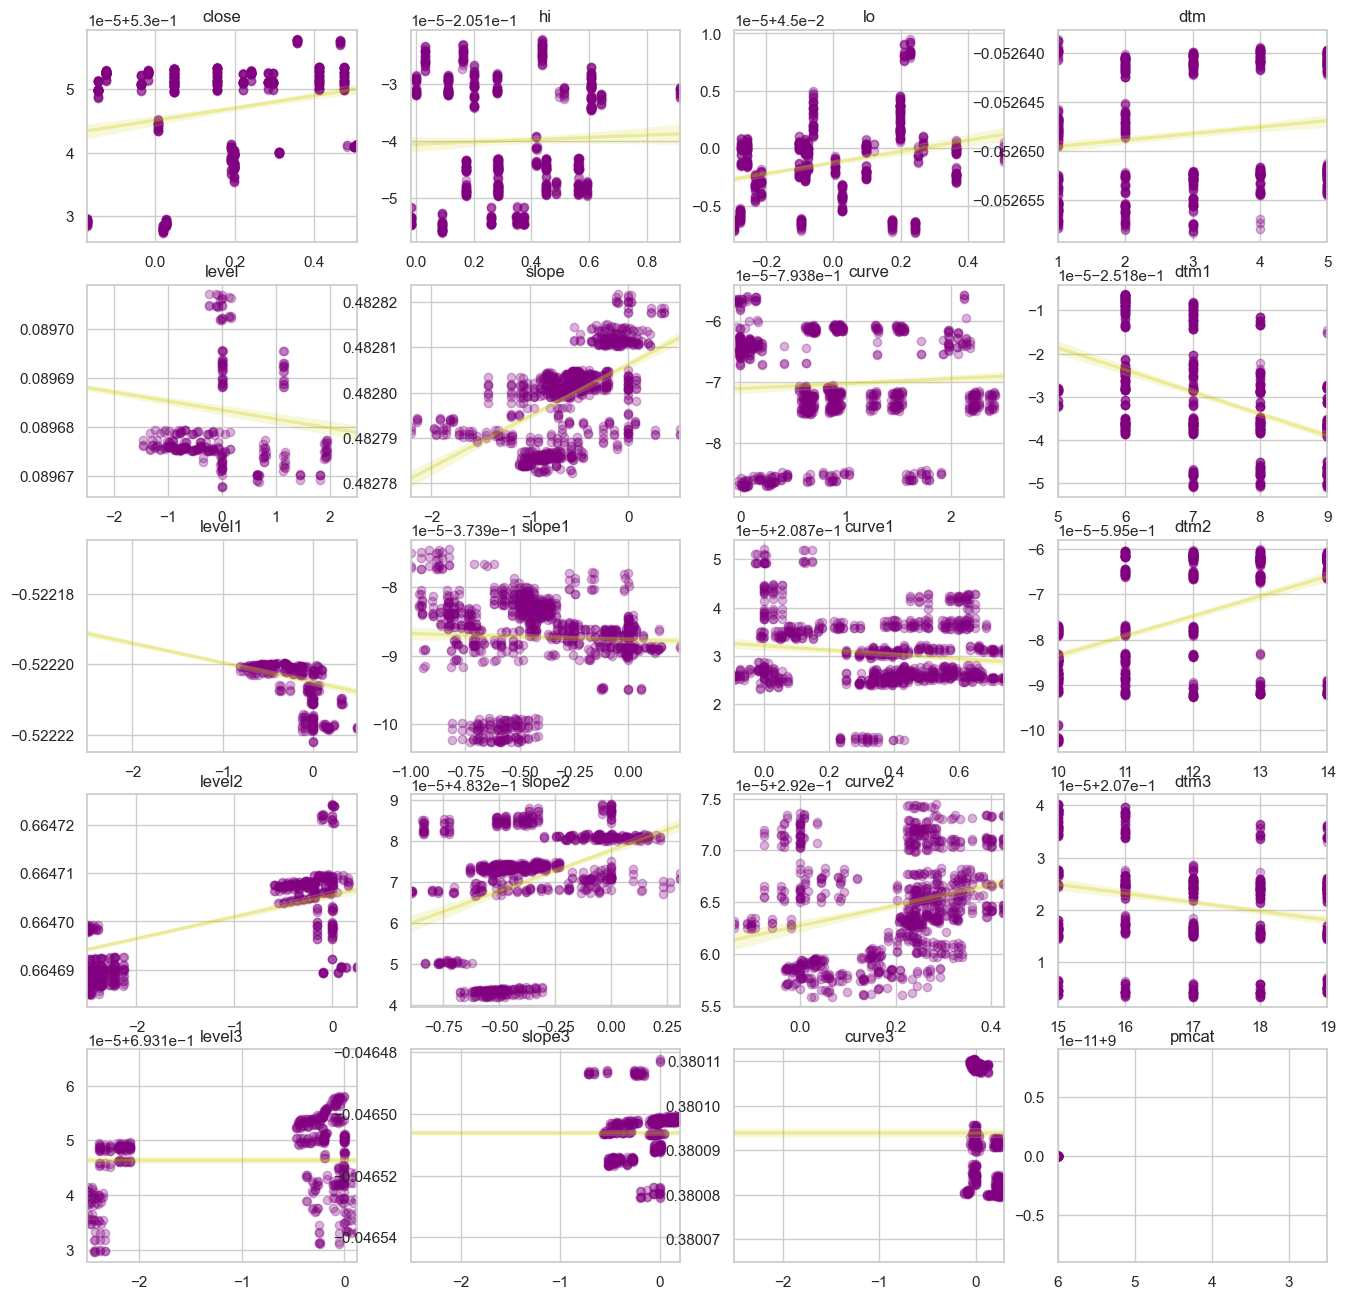

In [ ]:
validate()

In [ ]:
loss_fn=cross_entropy_mse_loss_with_nans
batch=next(zero.iter_batches(X['test'], batch_size))
p=apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2])
loss = loss_fn(
                p.squeeze(1),
                y_batch)

## export

In [ ]:
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
resume=True
ignore_load_zero=True
ignore_load_error=True

if len(dep_vars)>0:
  setup_data()
  with open(mydrive + jobname, 'wb') as filehandler:
      dump((my_model, y_std, y_mean, enc), filehandler)


Xcg_close,hi torch.Size([247117, 20])
PETrans 6 16 132 [] 40 2
loaded Xcg_close,hi epoch 212
offset  -68228


# valid

In [ ]:
last_run = "2023-08-30"
next_run = "2023-07-30"

models, cont_names = [], []
jobname = job_name()
with open(mydrive + jobname, 'rb') as filehandler:
    models.append(load(filehandler))

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    df = df.query(f'date>"#{next_run}"')
    dfo = pd.concat([dfo, df])

for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

enc=models[0][3]
dfo[cat_names] = enc.fit_transform(dfo[cat_names])


def val_period():
    global jobname, X, y, my_model, y_mean, y_std
    for period in [[last_run, '9999'], [next_run, last_run]]:
        print(period)
        df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
        dep_var=dep_vars[0]+dep_vars[1]
        X, y = ({'test':
                 (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                     torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                     torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                     torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                 )
                 }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
        print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
        y['test'][:,-1]-=1

        for learner in models:
            jobname = job_name()
            my_model, y_std, y_mean, enc = learner
            y['test'][y['test']==bad_value]=float('nan')
            cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
            y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
            validate()

In [ ]:
def val_period():
    global jobname, X, y, my_model, y_mean, y_std
    for period in [[last_run, '9999'], [next_run, last_run]]:
        print(period)
        df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
        dep_var=dep_vars[0]+dep_vars[1]
        X, y = ({'test':
                 (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                     torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                     torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                     torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                 )
                 }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
        print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
        y['test'][:,-1]-=1

        for learner in models:
            jobname = job_name()
            my_model, y_std, y_mean, enc = learner
            y['test'][y['test']==bad_value]=float('nan')
            cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
            y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
            validate()

['2023-08-30', '9999']
duration:  6 (5396, 156) torch.Size([5396, 0]) torch.Size([5396, 22, 6]) torch.Size([5396, 2])
Xcg_close,hi 3.6089


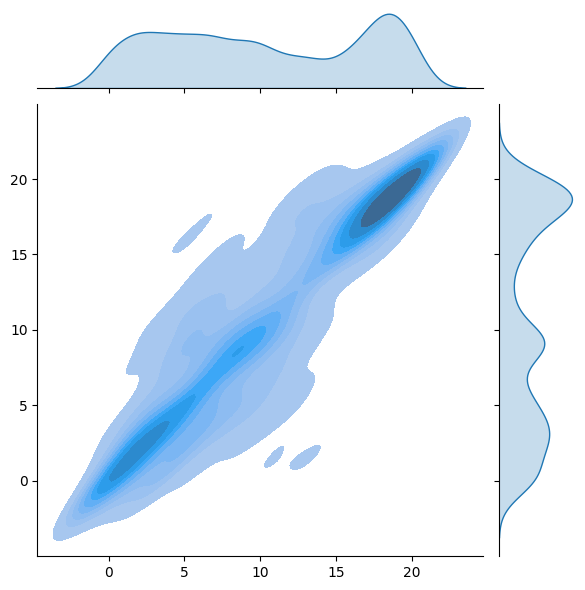

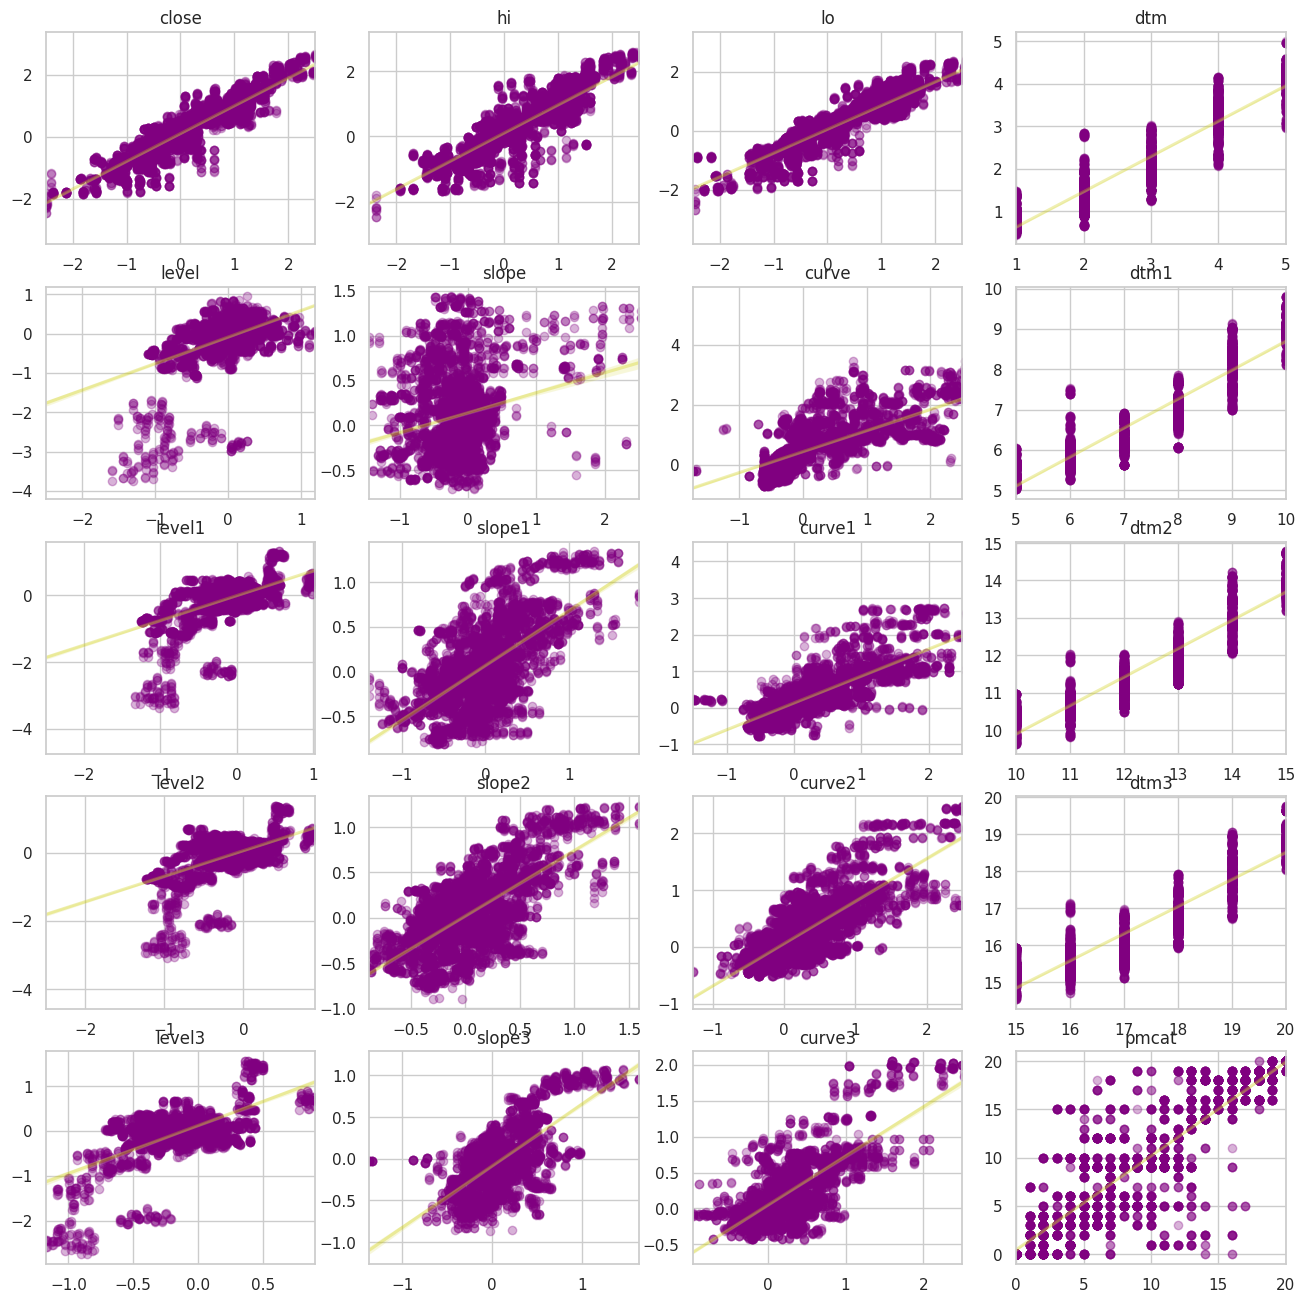

['2023-07-30', '2023-08-30']
duration:  6 (15484, 156) torch.Size([15484, 0]) torch.Size([15484, 22, 6]) torch.Size([15484, 2])
Xcg_close,hi 3.9391


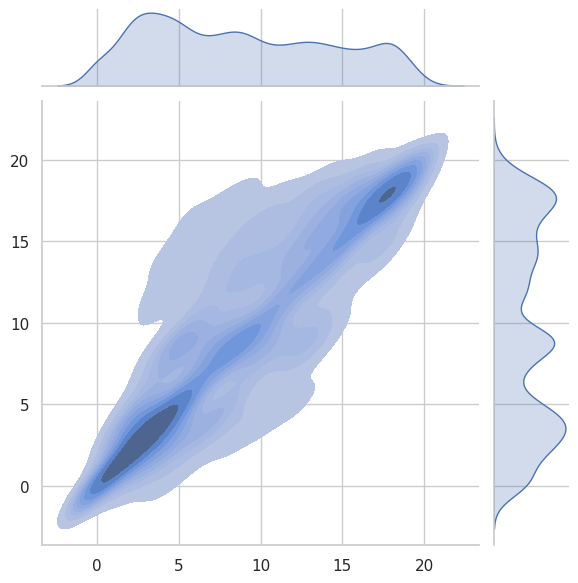

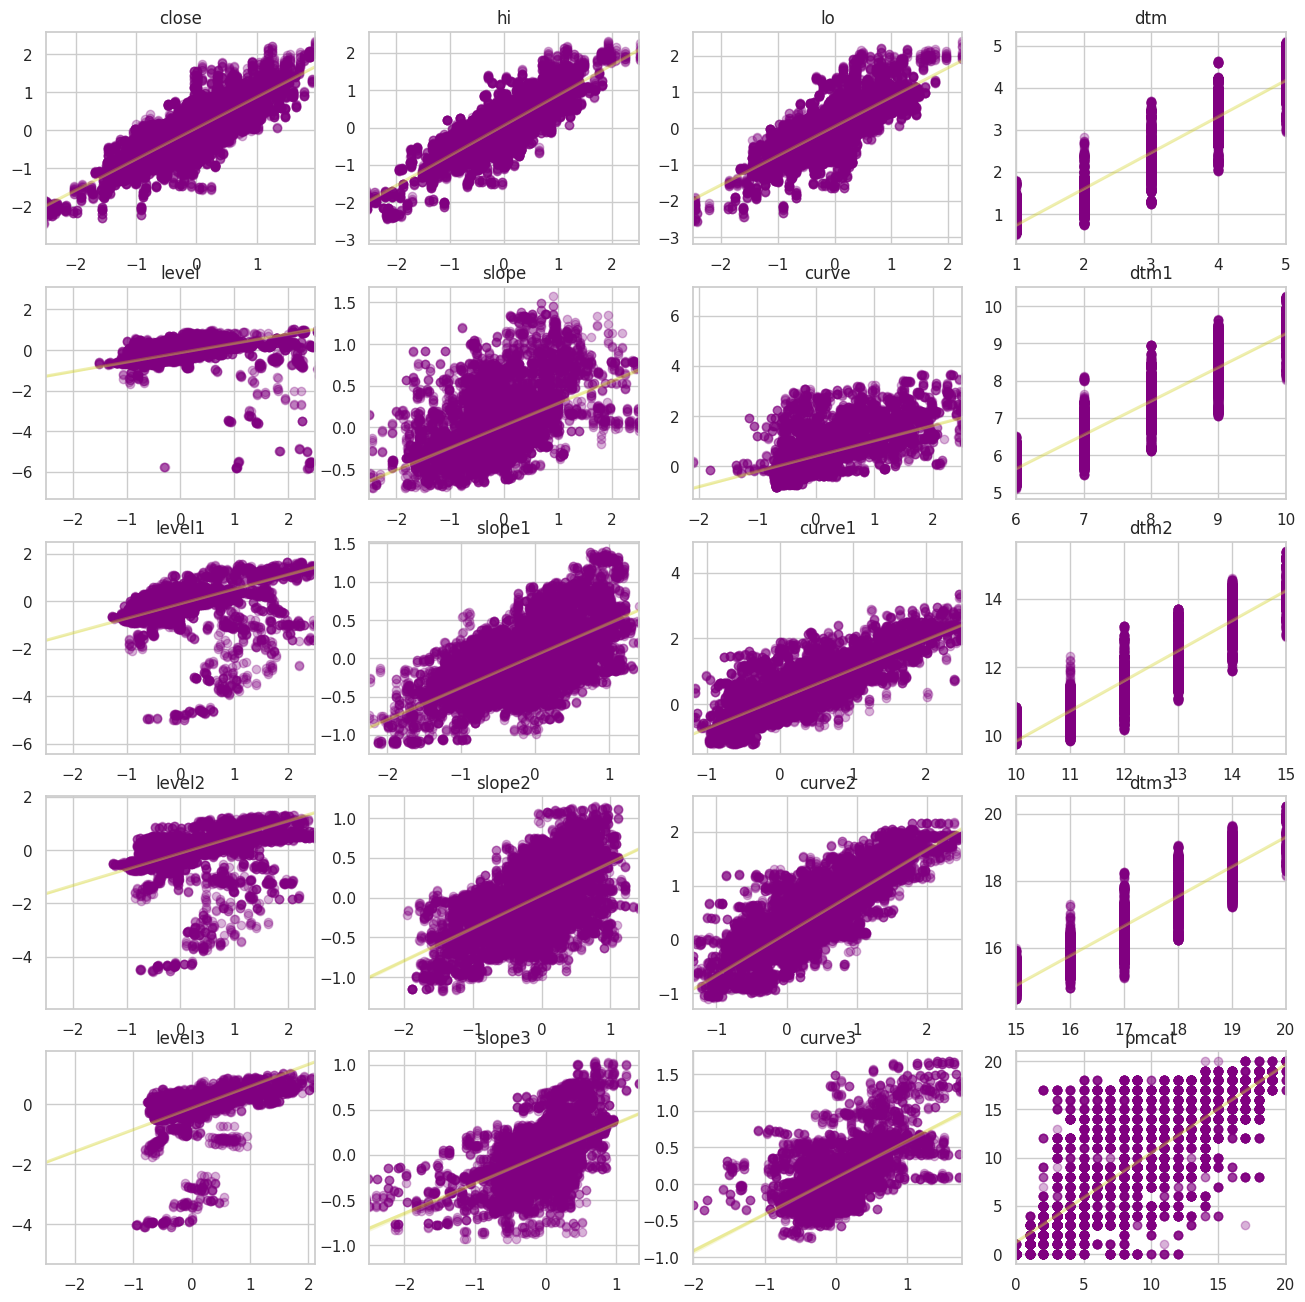

In [ ]:
val_period()

## after

In [ ]:
val_period()

# all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-tuvea_qg
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-tuvea_qg
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
GPU mem:16G, batch_size:256
(247117, 156) (247117, 134) 19
0.000000   -1.795700
0.048119   -0.719050
0.096238   -0.478971
0.144357   -0.331991
0.192476   -0.250342
0.240595   -0.184375
0.288713   -0.132440
0.336832   -0.089633
0.384951   -0.049250
0.433070   -0.014150
0.480733    0.010760
0.527939    0.044381
0.575145    0.082360
0.622351    0.120950
0.669557    0.165190
0.716763    0.212480
0.763969    0.262030
0.811176    0.319894
0.858

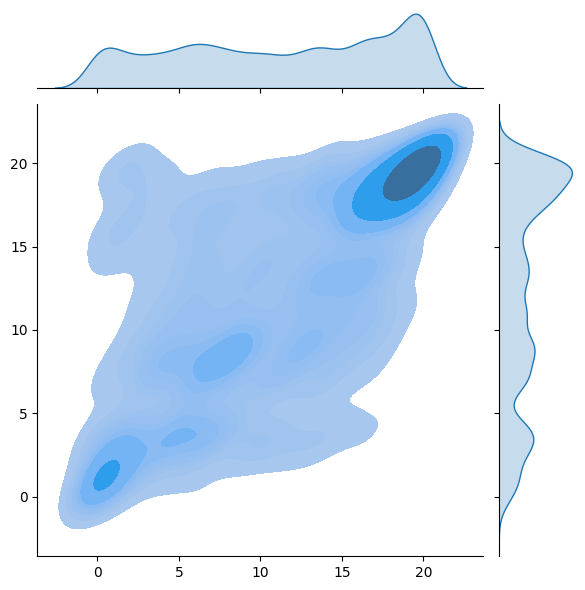

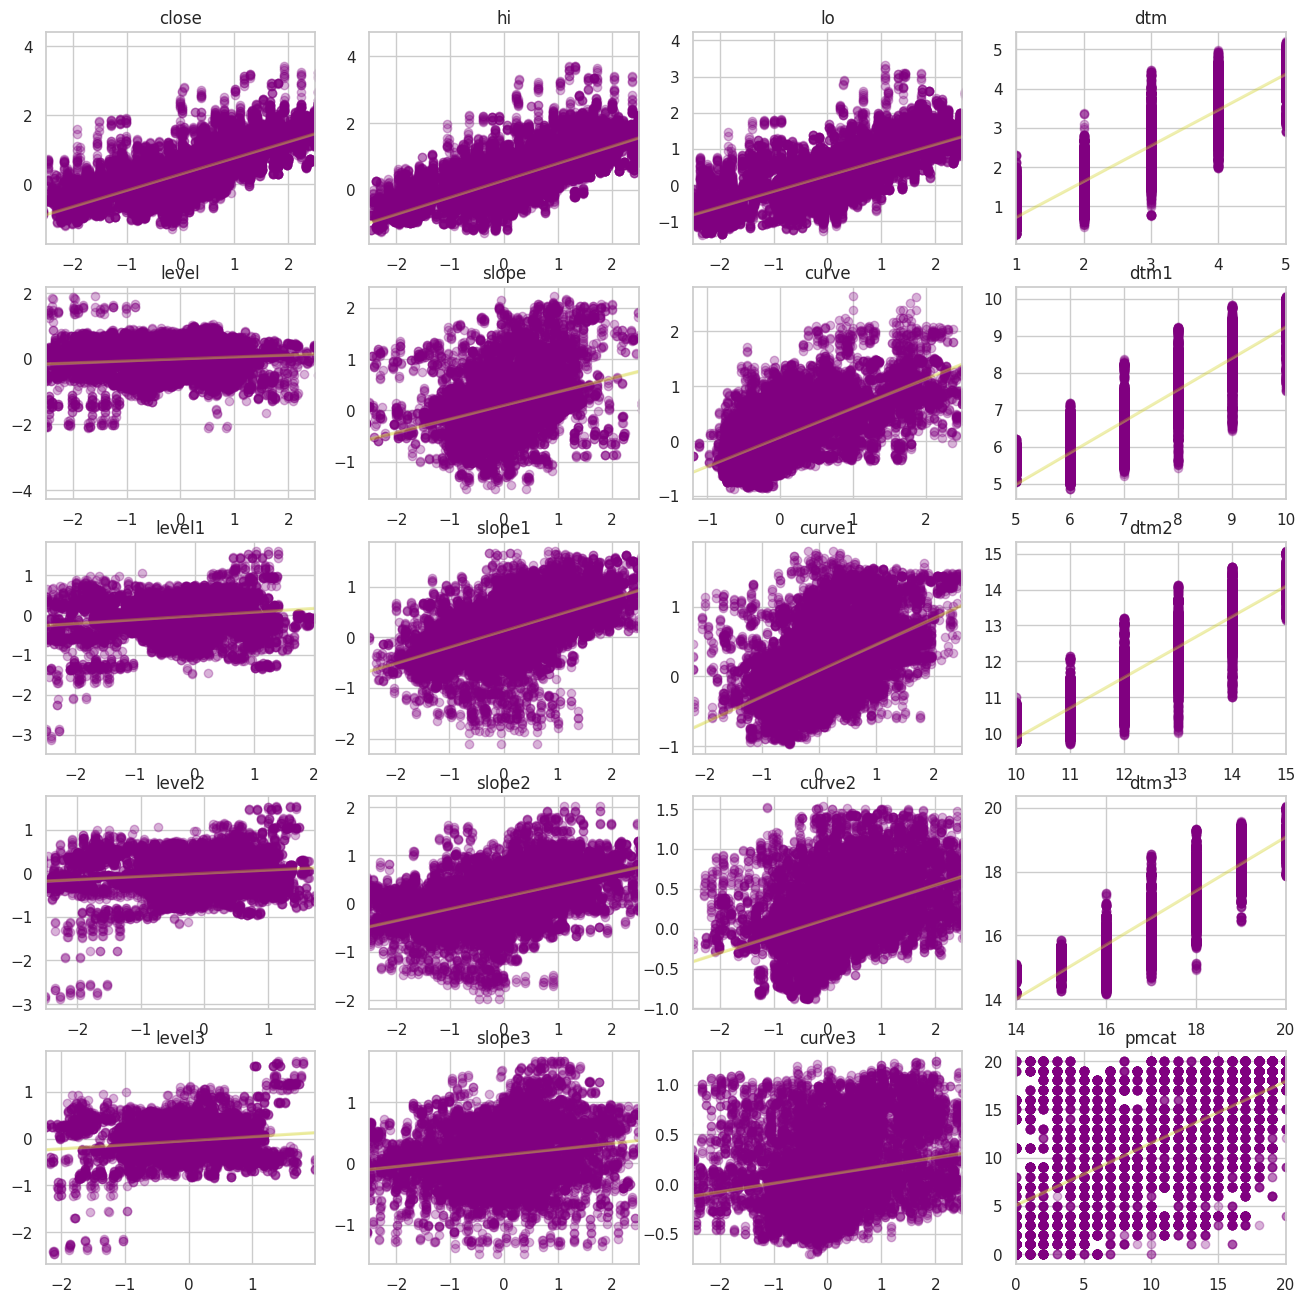

Epoch 302 | Validation score: 4.3599  <<< BEST VALIDATION EPOCH
Epoch 303 | Validation score: 4.4421  no improve 1
Epoch 304 | Validation score: 4.4130  no improve 2
Epoch 305 | Validation score: 4.4104  no improve 3
Epoch 306 | Validation score: 4.3229  <<< BEST VALIDATION EPOCH
Epoch 307 | Validation score: 4.4281  no improve 1
Epoch 308 | Validation score: 4.4230  no improve 2


In [ ]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/new/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xcg_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')

################################################## model ############################
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state
############################################## train ##########################################
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# batch_size = 256
# tables = ['volcva.csv']

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
# boxplot(vars_h[1:],bad_value)
# boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

############################################## run ##########################################
n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

# end

In [ ]:
X['test'][0][mini],X['test'][1][mini],X['test'][2][mini]


Xcc_close, h torch.Size([65185, 3])
PETrans 5 16 110 [8] 3 0
loaded Xcc_close, h epoch 357
offset  -15178


In [ ]:
print(f"date_1:{X['test'][1][mini][0][0]} dtm:{target[mini][0]} diff_1:{X['test'][1][mini][1][0]} dtm_1:{X['test'][1][mini][6][0]}Horizon:{X['test'][2][mini][0]}")
dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))]

tensor([ 0.0597,  0.1795, -0.0806], device='cuda:0', dtype=torch.float64)

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))].iloc[10])

In [ ]:
y['test']

tensor([[ 1.4684e+00,  1.8226e+00,  1.3640e+00,  ..., -9.9999e+04,
         -9.9999e+04,  2.0000e+01],
        [-6.2687e-01,  2.3860e-02, -6.4011e-01,  ..., -2.4437e-01,
         -1.4853e-01,  1.0000e+00],
        [ 1.8294e-01,  4.4767e-01,  1.0860e-02,  ..., -9.9999e+04,
         -9.9999e+04,  1.4000e+01],
        ...,
        [ 2.8748e-01,  4.4985e-01,  1.5132e-01,  ..., -3.5910e-02,
          7.1900e-03,  1.6000e+01],
        [-1.1756e-01,  9.0040e-02, -1.3910e-01,  ..., -9.9999e+04,
         -9.9999e+04,  6.0000e+00],
        [-2.3524e-01,  9.0840e-02, -2.4515e-01,  ..., -6.7920e-02,
         -1.7040e-02,  4.0000e+00]], device='cuda:0')